# Week 6: Data challenge

## Honk4Honda


# Problem

The data science team for Honda wants to understand the regional automotive demand in the US

Some initial market research reveals a strong demand for Hondas in Omaha, NE.

## Goals

Identify promising markets for Honda expansion <br>
    Find similar markets to that of Omaha, NE <br>
How do we know that we're not oversaturating the market? <br>
    Polynomial regression of car numbers in different regions <br>
Or expanding into a hostile market? <br>
    Identify popularity of other brands in these potential markets <br>

Elaborate on any interesting insights or trends <br>
    Through EDA

----------

# Exploratory Data Analysis

## Load data

In [1]:
# We will be using a Pandas dataframe to investigate the data
# Import pandas and numpy
import pandas as pd
import numpy as np

In [2]:
# Name the home directory where the original data file is located
dir_name = '/Users/mbeckert/Documents/code/insight_testing/data_challenges/week6/'

# Load in the data
car_df = pd.read_csv(dir_name + 'craigslistVehicles.csv')

## Data cleaning

In [3]:
car_df.keys()

Index(['url', 'city', 'city_url', 'price', 'year', 'manufacturer', 'make',
       'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'desc', 'lat', 'long'],
      dtype='object')

In [4]:
# Let's see the current shape of the dataframe
print('original shape = '+ str(car_df.shape))

# Check and drop duplicate rows
car_df = car_df.drop_duplicates()
print('new shape = ' + str(car_df.shape))

original shape = (443405, 22)
new shape = (443405, 22)


Okay great. It looks like there were not any duplicate rows to throw out.

In [5]:
# We will need the know the cities to perform our analysis.
# we have a couple sources that will satisfy this,
# the "city", "city_url", and combination of "lat" and "long" columns

# Let's try check which would be best.

# First, let's count the unique values
# If they are all equal then that suggests either there are no errors in the entries,
# Or that an error is systematic across the columns
# Still a useful quick first step


print('Num unique values for "city": ' + str(len(car_df['city'].unique())))
print('Num unique values for "city_url": ' + str(len(car_df['city_url'].unique())))

print('Num unique values for "lat" "long" combinations: ' 
      + str(len(car_df.groupby(['lat','long']).size().reset_index().rename(columns={0:'count'}))))


Num unique values for "city": 406
Num unique values for "city_url": 406
Num unique values for "lat" "long" combinations: 77675


Okay, so the latitudes and longitudes appear to be nearly all unique. <br>
So these are not the lat/longs for the city, but the lister's location. <br>
Therefore, we should not use these values 

But the unique values for "city" and "city_url" are the same length <br>
So we should check which will be easier to work with

In [6]:
print(car_df['city'].unique())
print(car_df['city_url'].unique())


['albuquerque' 'altoona-johnstown' 'amarillo, TX' 'ames, IA'
 'anchorage / mat-su' 'annapolis, MD' 'ann arbor, MI'
 'appleton-oshkosh-FDL' 'asheville, NC' 'ashtabula, OH' 'athens, GA'
 'athens, OH' 'atlanta, GA' 'auburn, AL' 'augusta, GA' 'austin, TX'
 'bakersfield, CA' 'baltimore, MD' 'baton rouge' 'battle creek, MI'
 'beaumont / port arthur' 'bellingham, WA' 'bemidji, MN' 'bend, OR'
 'billings, MT' 'binghamton, NY' 'birmingham, AL' 'bismarck, ND'
 'bloomington, IN' 'bloomington-normal' 'boise, ID' 'boone, NC' 'boston'
 'boulder, CO' 'bowling green, KY' 'bozeman, MT' 'brainerd, MN'
 'brownsville, TX' 'brunswick, GA' 'buffalo, NY' 'butte, MT'
 'cape cod / islands' 'catskills' 'cedar rapids, IA' 'central louisiana'
 'central michigan' 'central NJ' 'champaign urbana' 'charleston, SC'
 'charleston, WV' 'charlotte, NC' 'charlottesville, VA' 'chattanooga, TN'
 'chautauqua, NY' 'chicago' 'chico, CA' 'chillicothe, OH' 'cincinnati, OH'
 'clarksville, TN' 'cleveland, OH' 'clovis / portales'
 'c

These values all look like they make sense.

So let's just use the name itself and drop the other columns

In [7]:
# There are many columns that are not immediately helpful in determining 
# the market similarity and describing the market itself

# Let's drop those to make it the DF easier to handle
car_df = car_df.drop(columns = [
                    'url', 'city_url', 'make', 'VIN', 
                    'image_url', 'desc', 'lat', 'long',
                    'title_status'
                    ])

In [8]:
print('original shape ' + str(car_df.shape))
print('new shape ' + str(car_df.dropna(axis=0).shape))

# If we only take complete rows we reduce our dataset by a quarter.
# We will do this to be able to quickly start testing some models
# and drawing some conclusions

car_df = car_df.dropna(axis=0)

original shape (443405, 13)
new shape (95010, 13)


In [9]:
car_df.keys()

Index(['city', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'transmission', 'drive', 'size', 'type',
       'paint_color'],
      dtype='object')

In [10]:
# Let's check if the manufacturer names look alright
print(car_df['manufacturer'].unique())
print(len(car_df['manufacturer'].unique()))

['hyundai' 'ford' 'chevrolet' 'bmw' 'honda' 'ram' 'volkswagen' 'audi'
 'nissan' 'pontiac' 'dodge' 'gmc' 'jeep' 'chrysler' 'lexus' 'mitsubishi'
 'toyota' 'mazda' 'rover' 'kia' 'infiniti' 'subaru' 'cadillac' 'buick'
 'acura' 'mercedes-benz' 'lincoln' 'mini' 'volvo' 'saturn' 'mercury'
 'jaguar' 'fiat' 'datsun' 'ferrari' 'alfa-romeo' 'harley-davidson'
 'porche' 'hennessey' 'land rover' 'aston-martin']
41


Okay, it looks like that is alright as well.
We should be able to group the results as is.

In [11]:
# Checking the dtypes to get a feeling for what additional cleaning we may need to do

car_df.dtypes

city             object
price             int64
year            float64
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
transmission     object
drive            object
size             object
type             object
paint_color      object
dtype: object

We should convert year to an int.
We will group by manufacturer and city.
Condition, cylinders, drive, size, type, paint_color, and transmission are discrete categories

In [12]:
car_df['year'] = car_df['year'].apply(int)

In [13]:
for g in car_df.keys():
    print('unique values in ' + g)
    print(car_df[g].unique())

unique values in city
['albuquerque' 'altoona-johnstown' 'amarillo, TX' 'ames, IA'
 'anchorage / mat-su' 'annapolis, MD' 'ann arbor, MI'
 'appleton-oshkosh-FDL' 'asheville, NC' 'ashtabula, OH' 'athens, GA'
 'athens, OH' 'atlanta, GA' 'auburn, AL' 'augusta, GA' 'austin, TX'
 'bakersfield, CA' 'baltimore, MD' 'baton rouge' 'battle creek, MI'
 'beaumont / port arthur' 'bellingham, WA' 'bemidji, MN' 'bend, OR'
 'billings, MT' 'binghamton, NY' 'birmingham, AL' 'bismarck, ND'
 'bloomington, IN' 'bloomington-normal' 'boise, ID' 'boone, NC' 'boston'
 'boulder, CO' 'bowling green, KY' 'bozeman, MT' 'brainerd, MN'
 'brownsville, TX' 'brunswick, GA' 'buffalo, NY' 'butte, MT'
 'cape cod / islands' 'catskills' 'cedar rapids, IA' 'central louisiana'
 'central michigan' 'central NJ' 'champaign urbana' 'charleston, SC'
 'charleston, WV' 'charlotte, NC' 'charlottesville, VA' 'chattanooga, TN'
 'chautauqua, NY' 'chicago' 'chico, CA' 'chillicothe, OH' 'cincinnati, OH'
 'clarksville, TN' 'cleveland, OH' '

We will want to encode many of these variables to work in a numeric model. <br>
Condition, Cylinders, and Size can be ordinal encoded <br>
While Fuel, Transmission, Drive, Type, and Paint_color can be one-hot encoded

In [14]:
def categorize_ordinal(col, cats):
    cat = pd.Categorical(col, 
                     categories=cats, 
                     ordered=True)
    labels, unique = pd.factorize(cat, sort=True)
    return labels

In [15]:
# There is almost definitely a more elegant way to create the key,
# But because there are so few conditions and they are in real words,
# which is some cases are ambiguous level wise anyway
# it would not be worth the effort to come up with the solution.
# Rather just create the key by hand

print(car_df['condition'].unique())
print(car_df['cylinders'].unique())
print(car_df['size'].unique())

['good' 'excellent' 'fair' 'like new' 'salvage' 'new']
['4 cylinders' '8 cylinders' '6 cylinders' '10 cylinders' '5 cylinders'
 'other' '3 cylinders' '12 cylinders']
['mid-size' 'full-size' 'compact' 'sub-compact']


In [16]:
col = 'condition'
cats = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']

car_df[col] = categorize_ordinal(car_df[col], 
                        cats = cats)

In [17]:
col = 'cylinders'
cats = ['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', 
        '8 cylinders', '10 cylinders', '12 cylinders']

car_df[col] = categorize_ordinal(car_df[col], 
                        cats = cats)

# We have several elements termed "other" that we don't need
car_df = car_df[car_df.cylinders != -1]

In [18]:
col = 'size'
cats = ['sub-compact', 'compact', 'mid-size', 'full-size']

car_df[col] = categorize_ordinal(car_df[col], 
                        cats = cats)

In [19]:
# For time sake we will drop the features which should be one hot encoded
# and run the model with the features with numeric values

car_df = car_df.drop(columns=['fuel', 'transmission', 'drive', 'type', 'paint_color'])

In [20]:
# Price and Odometer have some weird values
# We need to remove them

car_df = car_df.loc[car_df['price'] <= np.percentile(car_df['price'], 90)]
car_df = car_df.loc[car_df['odometer'] <= np.percentile(car_df['odometer'], 90)]

In [21]:
# For the initial analysis we can do the 'groupby' city and brand now

car_df_group = car_df.groupby(['manufacturer', 'city']).mean()

In [22]:
# Let's scale all values to make the results a little more interpretable

# feature scaling
from sklearn import preprocessing

for x in car_df_group.keys():
    car_df_group[x] = preprocessing.scale(car_df_group[x])

## Where is Omaha?

In [23]:
# We need to check where "omaha, NE" exists in our data
for i in car_df['city'].unique():
    if 'om' in i:
        print(i)

bloomington, IN
bloomington-normal
kokomo, IN
montgomery, AL
oklahoma city
omaha / council bluffs
seattle-tacoma
texoma
utica-rome-oneida
wyoming


Okay Omaha is there. But is it Omaha, NE? <br>
A quick google search says it the 'council bluffs' are in Iowa <br>
We can't let this confuse us. <br>
"omaha /council bluffs" is the Iowa side of Omaha, NE <br>
So we will take this as the market we need to find similar matches to

In [24]:
# Let's just look at some other Nebraskan cities if people are not satisfied with Omaha, Iowa
for i in car_df['city'].unique():
    if 'NE' in i:
        print(i)

grand island, NE
lincoln, NE
north platte, NE


Using Google Maps the distance from Omaha, NE:

Grand Island, NE: 150 miles <br>
Lincoln, NE: 60 miles <br>
North Platte, NE: 280 miles <br>

So if we want you can easily substitute in Lincoln, NE into our model if you would prefer.

In [25]:
# Also, let's check how many instances we have for these two cities

instance_count = car_df.groupby('city').count()
print(str(instance_count['price'].loc['omaha / council bluffs']))
print(str(instance_count['price'].loc['lincoln, NE']))
print(sum(instance_count['price']) / len(instance_count['price']))

293
223
189.13793103448276


Okay good. <br>
The average number of entries for each city is 189. <br>
And both Omaha and Lincoln both have between 200 and 300

## Exploratory plots

Let's make some plots to get a feel for what we have left

In [26]:
# import matplotlib
import matplotlib.pyplot as plt

In [27]:
# Some basic description
car_df_group.describe()

price          year     condition     cylinders      odometer  \
count  8.994000e+03  8.994000e+03  8.994000e+03  8.994000e+03  8.994000e+03   
mean  -3.626679e-17 -1.056504e-14  3.918986e-16  7.573958e-15 -1.245761e-16   
std    1.000056e+00  1.000056e+00  1.000056e+00  1.000056e+00  1.000056e+00   
min   -1.848301e+00 -9.793770e+00 -4.987180e+00 -2.522302e+00 -3.151335e+00   
25%   -7.081755e-01 -3.606098e-01 -6.126544e-01 -8.545738e-01 -5.784151e-01   
50%   -7.210545e-02  1.539262e-01  9.110457e-02  2.919891e-01  3.440529e-02   
75%    5.770117e-01  5.827062e-01  6.372102e-01  7.297677e-01  6.116095e-01   
max    3.878730e+00  2.040558e+00  4.386804e+00  3.481519e+00  2.715805e+00   

               size  
count  8.994000e+03  
mean  -4.964847e-15  
std    1.000056e+00  
min   -3.514682e+00  
25%   -3.540413e-01  
50%    9.105694e-02  
75%    7.952825e-01  
max    1.226279e+00

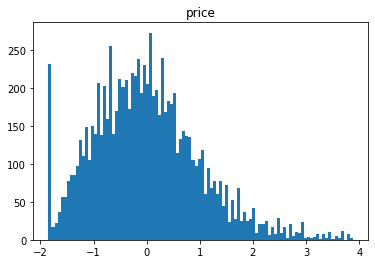

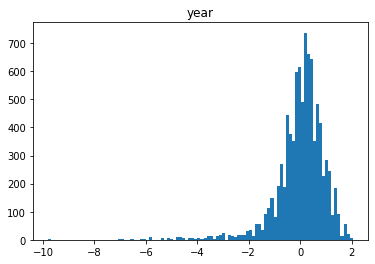

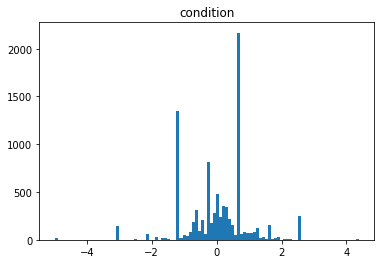

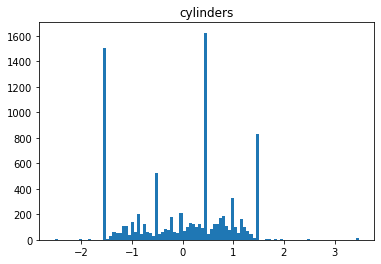

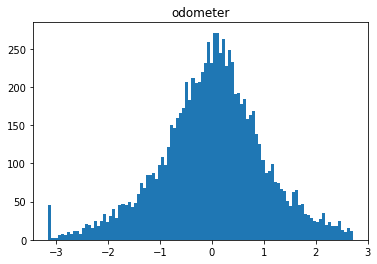

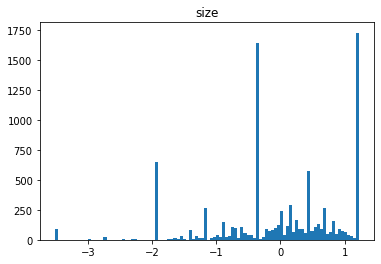

In [28]:
# Plot histograms to look at their distributions

for i, x in enumerate(car_df_group.keys()):
    plt.figure()
    plt.hist(car_df_group[x], bins=100)
    plt.title(x)

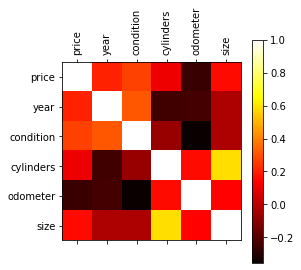

In [29]:
# Let's also look at any potential correlations in the data
plt.matshow(car_df_group.corr(), cmap='hot')
plt.colorbar()
plt.xticks(range(len(car_df_group.keys())), car_df_group.keys(), rotation=90)
plt.yticks(range(len(car_df_group.keys())), car_df_group.keys())
plt.show()

Size and cylinders are highly correlated, which makes sense.
We may consider removing one of these in the model

# Modeling

To try and find similar markets as Omaha, NE we can try a few things. <br>
We can look at a K-means clustering <br>
Another potential method is to do a cosine similarity, reminiscent of a recommender system <br>
I am slightly more familiar with the cosine similarity, so we will try this first

In [30]:
# Restructuring back to a simple dataframe rather than the multiindex
car_df_group = car_df_group.reset_index(level=[0, 1])


## Calculate the cosine similarity

In [31]:

from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(car_df_group.drop(columns = ['manufacturer', 'city']).values, dense_output=True)

In [32]:
keys = car_df_group[['manufacturer', 'city']]

<Figure size 504x504 with 0 Axes>

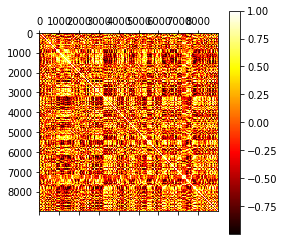

In [33]:
# Plot the similarity matrix
plt.figure(figsize=(7,7))
plt.matshow(sim, cmap='hot')
plt.colorbar()
#plt.xticks(range(len(keys)), (keys['manufacturer'] + '___' + keys['city']), rotation=90)
#plt.yticks(range(len(keys)), (keys['manufacturer'] + '___' + keys['city']))
plt.show()

Cool, we have some structure in our data on what cities seem to have similar preferences

In [34]:
l1= np.argwhere(keys['manufacturer'] == 'honda').flatten()
l2 = np.argwhere(keys['city'] == 'omaha / council bluffs').flatten()
omaha_id = list(set(l1) & set(l2))
omaha_sim = sim[omaha_id, :][0]                                           

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


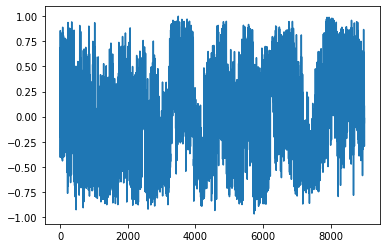

In [35]:
plt.plot(omaha_sim)
plt.show()

## Provide predictions on new markets
Based on the most similar markets
And if this potential market is a larger competitor

In [36]:
# Find the top 1% of markets
nearest_neighbors = np.flipud(np.argsort(omaha_sim))
neighbors = keys.iloc[nearest_neighbors[0:86]]

neighbors = neighbors.loc[neighbors['manufacturer'] != 'honda']
neighbors = neighbors.reset_index()
neighbors = neighbors.drop(columns='index')

In [37]:
# Compute the relative amount of the market each manufacturer occupies in the current city
car_compete = car_df.groupby(['city', 'manufacturer']).count()
car_compete = car_compete['price']

In [38]:
# Here is an example of the best market
# Where the most similar item only occupies 2% of the market
# And honda currently only occupies 7%
# And the current largest occupier is 24%
ix = 0

compete_m = neighbors['manufacturer'].iloc[ix]
new_city = neighbors['city'].iloc[ix]

print(compete_m)
print(new_city)

print(str(np.round(car_compete.loc[new_city].loc[compete_m] /
      sum(car_compete.loc[new_city])*100, 2)))
print(str(np.round(car_compete.loc[new_city].loc['honda'] / 
      sum(car_compete.loc[new_city])*100, 2)))
print(str(np.round(np.max(car_compete.loc[new_city]) / 
      sum(car_compete.loc[new_city])*100, 2)))
print()

subaru
fredericksburg, VA
1.93
7.4
24.12



## Now let's run through all of the top recommendations
We will provide an output to the Honda

In [39]:
new_city = []
honda_per = []
nearest_man = []
nearest_per = []
compete_man = []
compete_per = []


for i in range(len(neighbors)):
    city = neighbors['city'].iloc[i]
    compete = neighbors['manufacturer'].iloc[i]
    
    new_city.append(city)
    try:
        honda_per.append(np.round(car_compete.loc[city].loc['honda'] / sum(car_compete.loc[city])*100, 2))
    except:
        honda_per.append(0.00)
    nearest_man.append(compete)
    nearest_per.append(np.round(car_compete.loc[city].loc[compete] /sum(car_compete.loc[city])*100, 2))
    compete_man.append(np.argmax(car_compete.loc[city]))
    compete_per.append(np.round(np.max(car_compete.loc[city]) / sum(car_compete.loc[city])*100, 2))
    
    

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [40]:
prediction_output = pd.DataFrame(
    {'new_city'   : new_city,
     'honda_per'  : honda_per,
     'nearest_man': nearest_man,
     'nearest_per': nearest_per,
     'compete_man': compete_man,
     'compete_per': compete_per}
)

In [41]:
prediction_output

new_city  honda_per nearest_man  nearest_per compete_man  \
0        fredericksburg, VA       7.40      subaru         1.93        ford   
1                    boston       6.86      subaru         3.01        ford   
2         northern michigan       3.19      subaru         1.60   chevrolet   
3             rochester, NY       6.67      subaru         5.00   chevrolet   
4             cleveland, OH       5.40      subaru         0.87   chevrolet   
5             lehigh valley       9.38      subaru         5.21        ford   
6               jackson, MS       4.03     hyundai         2.01   chevrolet   
7      appleton-oshkosh-FDL       3.17      subaru         2.21        ford   
8   fort collins / north CO       3.85      subaru         5.56        ford   
9              indianapolis       7.16  volkswagen         4.17   chevrolet   
10           pittsburgh, PA       4.00      subaru         4.40        ford   
11           ventura county       5.87      subaru         1.31        ford   
12            ann arbor, MI       6.67      subaru         2.12        ford   
13          kansas city, MO       4.49      subaru         1.42        ford   
14              oneonta, NY       5.00     hyundai         7.50        ford   
15               athens, GA       8.00      subaru         3.20        ford   
16              boulder, CO       3.70      subaru        14.29      subaru   
17        winston-salem, NC       4.59         kia         2.42        ford   
18           charleston, SC       4.85     hyundai         2.73        ford   
19             syracuse, NY       7.36      nissan         3.22        ford   
20         myrtle beach, SC       1.37      nissan         2.74        ford   
21               peoria, IL       3.43         kia         1.14   chevrolet   
22             stockton, CA       7.31  volkswagen         3.88      toyota   
23             north jersey      14.06        audi         2.76       honda   
24       cape cod / islands       3.48      toyota        13.04        ford   
25        north mississippi       0.96     hyundai         4.81        ford   
26           winchester, VA       7.82  volkswagen         2.28        ford   
27              northern WI       1.79      subaru         3.57   chevrolet   
28             columbus, OH      10.69      subaru         1.51        ford   
29         cedar rapids, IA       5.90        audi         0.59   chevrolet   
..                      ...        ...         ...          ...         ...   
35               central NJ       9.39      subaru         2.31        ford   
36             high rockies       1.92      subaru        12.50        ford   
37             billings, MT       7.91      subaru         1.90        ford   
38          santa maria, CA      12.20         kia         2.44        ford   
39           montgomery, AL       2.50       mazda         1.67   chevrolet   
40                   boston       6.86      toyota        10.54        ford   
41               denver, CO       6.21      subaru        10.02        ford   
42              albuquerque       5.00     hyundai         3.33        ford   
43            asheville, NC       4.63       mazda         2.06        ford   
44           harrisburg, PA       6.63      subaru         1.79        ford   
45         sierra vista, AZ       2.56     hyundai         2.56   chevrolet   
46           charleston, SC       4.85         kia         1.52        ford   
47              little rock       2.63         bmw         2.63   chevrolet   
48    western massachusetts      10.17      subaru         5.73        ford   
49            oklahoma city       2.26         kia         1.69   chevrolet   
50         corvallis/albany       5.23      subaru         3.27        ford   
51              little rock       2.63      subaru         1.32   chevrolet   
52                   boston       6.86  mitsubishi         0.17        ford   
53     appleton-oshkosh-FDL       3.17         kia         1.52      

# Conclusions

Here I am using cosine similarity in a manner similar to a content based recommendation system. <br>
It provides a list of potential markets Honda can expand into considering what the most similar competitor as well as the top competitor would be. <br>